In [33]:
from pathlib import Path

import numpy as np
import pandas as pd
from pandas.api.types import is_integer_dtype
import matplotlib.pyplot as plt

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.augmentations import ClassificationSMOTE

plt.style.use("./auri.mplstyle")

## load data

In [34]:
df_orig = pd.read_parquet('output/data.parquet')

In [35]:
df_orig.dtypes

X                float64
Y                float64
A8                object
A10               object
A13               object
A14              float64
A18              float64
A19               object
A20               object
NEAR_DIST        float64
fire_1km_c       float64
fire_1km2_       float64
fire_500m_       float64
gd_zone          float64
gg_zone          float64
jd_zone          float64
pr_zone          float64
si_zone          float64
crime_zone       float64
fire               int32
fire_1km_cnt       int64
fire_1km2_cnt      int64
fire_500m_cnt      int64
year               Int64
dtype: object

In [36]:
df_orig.fire.value_counts()

0    519631
1     20480
Name: fire, dtype: int64

## prepare balanced dataset

In [37]:
df_1 = df_orig[df_orig.fire == 1]
np.random.seed(1106)
df_0 = df_orig[df_orig.fire == 0].sample(n=len(df_1))

In [38]:
len(df_1), len(df_0)

(20480, 20480)

In [39]:
np.random.seed(1106)
df = pd.concat([df_1, df_0]).sample(frac=1).reset_index(drop=True)
df = df[['A8', 'A10', 'A14', 'A18', 'A20', 'gd_zone', 'gg_zone',
       'jd_zone', 'pr_zone', 'si_zone', 'crime_zone', 'fire', 'fire_1km_cnt',
       'fire_1km2_cnt', 'fire_500m_cnt', 'year']]
df

,A8,A10,A14,A18,A20,gd_zone,gg_zone,jd_zone,pr_zone,si_zone,crime_zone,fire,fire_1km_cnt,fire_1km2_cnt,fire_500m_cnt,year
0,01000,11,187.74,99.80000,N,0.00000,0.000000,0.000681,0.000787,0.00000,0.001468,0,294,102,85,1989
1,01000,19,95.87,0.00000,N,0.00000,0.000000,0.000030,0.000028,0.00000,0.000058,0,23,6,5,<NA>
2,01000,21,271.68,245.47000,N,0.00000,0.000000,0.000524,0.000395,0.00000,0.000919,0,156,45,33,2007
3,04000,21,668.21,189.05000,N,0.00000,0.000042,0.001175,0.001340,0.00000,0.002558,0,43,26,19,1992
4,03000,21,283.06,0.00000,N,0.00000,0.000088,0.000458,0.000871,0.00000,0.001417,1,115,40,36,1991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40955,01000,11,69.28,49.84000,N,0.00000,0.000000,0.000108,0.000214,0.00000,0.000322,0,165,60,48,1968
40956,04000,21,426.90,182.89733,N,0.00000,0.000138,0.002093,0.001374,0.00000,0.003605,1,186,98,86,1995
40957,04000,21,630.95,0.00000,N,0.00001,0.000742,0.001291,0.001512,0.00001,0.003564,1,140,62,57,1990
40958,02000,21,308.90,243.70000,N,0.00000,0.000047,0.000385,0.000431,0.00000,0.000863,0,127,38,34,1995


In [40]:
np.random.seed(1106)
df["set"] = np.random.choice(['train', 'valid', 'test'], p=[.8, .1, .1], size=len(df))

df[["fire", "set"]].head(30)

,fire,set
0,0,train
1,0,train
2,0,test
3,0,valid
4,1,train
5,0,train
6,1,train
7,0,train
8,1,valid
9,0,train


In [41]:
train_idx = df[df.set == "train"].index
valid_idx = df[df.set == "valid"].index
test_idx = df[df.set == "test"].index

In [42]:
df.columns

Index(['A8', 'A10', 'A14', 'A18', 'A20', 'gd_zone', 'gg_zone', 'jd_zone',
       'pr_zone', 'si_zone', 'crime_zone', 'fire', 'fire_1km_cnt',
       'fire_1km2_cnt', 'fire_500m_cnt', 'year', 'set'],
      dtype='object')

In [43]:
categorical_columns = ["A8", "A10", "A20", "fire"]
categorical_classes = {}
categorical_dims = {}

for col in categorical_columns:
    print(col, df[col].nunique())
    l_enc = LabelEncoder()
    l_enc.fit(df_orig[col].fillna("N_A").values)
    df[col] = df[col].fillna("N_A")
    df[col] = l_enc.transform(df[col].values)
    categorical_classes[col] = l_enc.classes_
    categorical_dims[col] = len(l_enc.classes_)

print(categorical_classes)


A8 32
A10 21
A20 2
fire 2
{'A8': array(['01000', '02000', '03000', '04000', '05000', '06000', '07000',
       '08000', '09000', '10000', '11000', '12000', '13000', '14000',
       '15000', '16000', '17000', '18000', '19000', '20000', '21000',
       '22000', '23000', '24000', '25000', '26000', '27000', '29000',
       '31000', 'N_A', 'Z3000', 'Z5000', 'Z6000', 'Z8000', 'Z9000'],
      dtype=object), 'A10': array(['10', '11', '12', '13', '19', '21', '22', '26', '29', '30', '31',
       '32', '33', '37', '39', '40', '41', '42', '43', '49', '50', '51',
       '52', '53', '61', '63', '74', '99', 'N_A'], dtype=object), 'A20': array(['N', 'N_A', 'Y'], dtype=object), 'fire': array([0, 1])}


In [44]:
df.dtypes

A8                 int32
A10                int32
A14              float64
A18              float64
A20                int32
gd_zone          float64
gg_zone          float64
jd_zone          float64
pr_zone          float64
si_zone          float64
crime_zone       float64
fire               int64
fire_1km_cnt       int64
fire_1km2_cnt      int64
fire_500m_cnt      int64
year               Int64
set               object
dtype: object

In [45]:
numerical_columns = [
    "A14",
    "A18",
    "fire_1km_cnt",
    "fire_1km2_cnt",
    "fire_500m_cnt",
    "crime_zone",
    "gd_zone",
    "gg_zone",
    "jd_zone",
    "pr_zone",
    "si_zone",
    "year",
]

df[numerical_columns] = df[numerical_columns].astype(float)
for col in numerical_columns:
    m_train = df.loc[train_idx,col].mean()
    m_valid = df.loc[valid_idx,col].mean()
    m_test = df.loc[test_idx,col].mean()
    df.loc[train_idx,col] = df.loc[train_idx,col].fillna(m_train)
    df.loc[valid_idx,col] = df.loc[valid_idx,col].fillna(m_valid)
    df.loc[test_idx,col] = df.loc[test_idx,col].fillna(m_test)

In [46]:
df.dtypes

A8                 int32
A10                int32
A14              float64
A18              float64
A20                int32
gd_zone          float64
gg_zone          float64
jd_zone          float64
pr_zone          float64
si_zone          float64
crime_zone       float64
fire               int64
fire_1km_cnt     float64
fire_1km2_cnt    float64
fire_500m_cnt    float64
year             float64
set               object
dtype: object

In [47]:
df.isna().any()

A8               False
A10              False
A14              False
A18              False
A20              False
gd_zone          False
gg_zone          False
jd_zone          False
pr_zone          False
si_zone          False
crime_zone       False
fire             False
fire_1km_cnt     False
fire_1km2_cnt    False
fire_500m_cnt    False
year             False
set              False
dtype: bool

In [48]:
df.head()

,A8,A10,A14,A18,A20,gd_zone,gg_zone,jd_zone,pr_zone,si_zone,crime_zone,fire,fire_1km_cnt,fire_1km2_cnt,fire_500m_cnt,year,set
0,0,1,187.74,99.80,0,0.0,0.000000,0.000681,0.000787,0.0,0.001468,0,294.0,102.0,85.0,1989.000000,train
1,0,4,95.87,0.00,0,0.0,0.000000,0.000030,0.000028,0.0,0.000058,0,23.0,6.0,5.0,1990.798931,train
2,0,5,271.68,245.47,0,0.0,0.000000,0.000524,0.000395,0.0,0.000919,0,156.0,45.0,33.0,2007.000000,test
3,3,5,668.21,189.05,0,0.0,0.000042,0.001175,0.001340,0.0,0.002558,0,43.0,26.0,19.0,1992.000000,valid
4,2,5,283.06,0.00,0,0.0,0.000088,0.000458,0.000871,0.0,0.001417,1,115.0,40.0,36.0,1991.000000,train


## features for categorical embeddings

In [49]:
features = [col for col in df.columns if col not in ["set", "fire"]]
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for _, f in enumerate(features) if f in categorical_columns]

## tabnet parameters

In [50]:
tabnet_params = {
    "cat_idxs": cat_idxs,
    "cat_dims": cat_dims,
    "cat_emb_dim": 1,
    "optimizer_fn": torch.optim.Adam,
    "optimizer_params": dict(lr=2e-2),
    "scheduler_params": {
        "step_size": 50,  # how to use learning rate scheduler
        "gamma": 0.9,
    },
    "scheduler_fn": torch.optim.lr_scheduler.StepLR,
    "mask_type": "entmax",  # "sparsemax"
}

clf = TabNetClassifier(**tabnet_params)

c:\Users\USER\Documents\pytorchgpu\venv\lib\site-packages\pytorch_tabnet\abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [51]:
X_train = df[features].values[train_idx]
X_valid = df[features].values[valid_idx]
X_test = df[features].values[test_idx]

y_train = df["fire"].values[train_idx]
y_valid = df["fire"].values[valid_idx]
y_test = df["fire"].values[test_idx]


In [52]:
aug = ClassificationSMOTE(p=0.2)

In [53]:
if "histories" not in locals():
    histories = []

clf.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=["train", "valid"],
    eval_metric=["auc"],
    max_epochs=200,
    patience=20,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    augmentations=aug,  # aug, None
)
histories.append(clf.history)

epoch 0  | loss: 0.73704 | train_auc: 0.47318 | valid_auc: 0.46698 |  0:00:01s
epoch 1  | loss: 0.67624 | train_auc: 0.6183  | valid_auc: 0.63366 |  0:00:03s
epoch 2  | loss: 0.66401 | train_auc: 0.63633 | valid_auc: 0.6515  |  0:00:05s
epoch 3  | loss: 0.66118 | train_auc: 0.63926 | valid_auc: 0.65512 |  0:00:07s
epoch 4  | loss: 0.66056 | train_auc: 0.64094 | valid_auc: 0.657   |  0:00:09s
epoch 5  | loss: 0.66004 | train_auc: 0.63796 | valid_auc: 0.65265 |  0:00:10s
epoch 6  | loss: 0.66151 | train_auc: 0.64009 | valid_auc: 0.65509 |  0:00:12s
epoch 7  | loss: 0.66019 | train_auc: 0.63996 | valid_auc: 0.65379 |  0:00:14s
epoch 8  | loss: 0.65672 | train_auc: 0.63997 | valid_auc: 0.65281 |  0:00:16s
epoch 9  | loss: 0.66042 | train_auc: 0.64367 | valid_auc: 0.65479 |  0:00:17s
epoch 10 | loss: 0.66032 | train_auc: 0.64513 | valid_auc: 0.65635 |  0:00:19s
epoch 11 | loss: 0.65909 | train_auc: 0.64714 | valid_auc: 0.65913 |  0:00:21s
epoch 12 | loss: 0.65853 | train_auc: 0.64636 | vali

c:\Users\USER\Documents\pytorchgpu\venv\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [54]:
clf.best_epoch

63

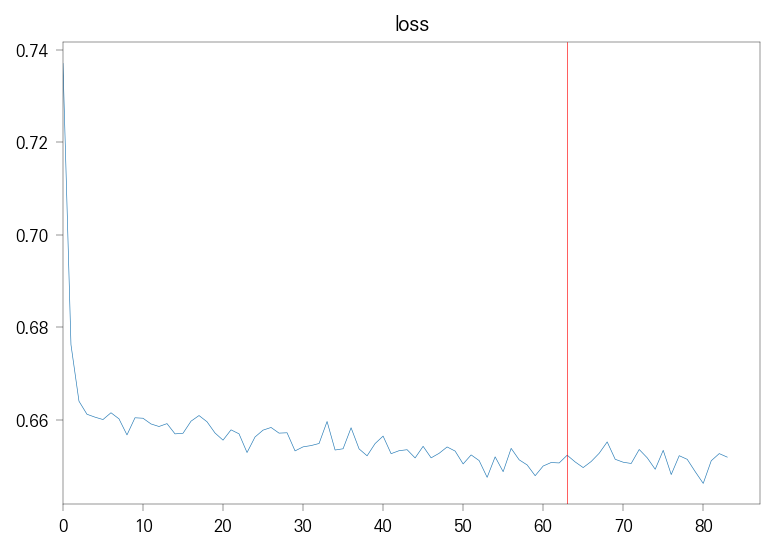

In [55]:
plt.plot(clf.history['loss'])
plt.axvline(clf.best_epoch,color='r')

plt.xlim(left=0)
plt.title("loss")
plt.savefig("output/loss.svg")
plt.savefig("output/loss.png")

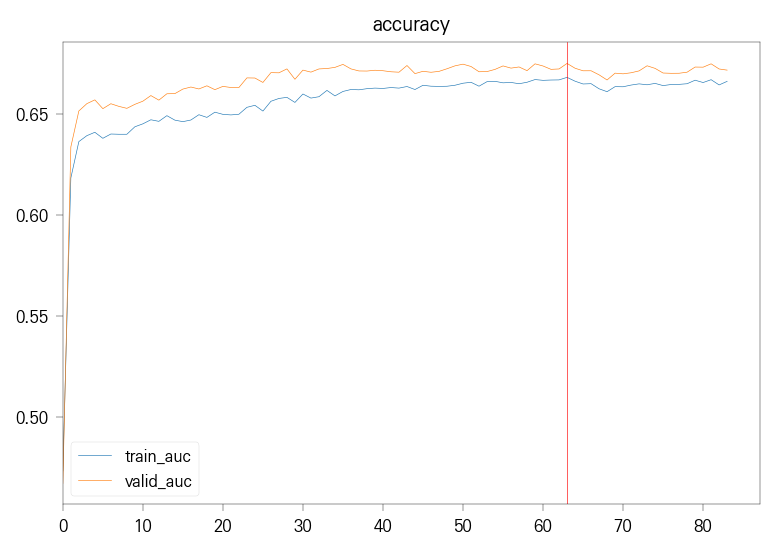

In [56]:
plt.plot(clf.history['train_auc'], label="train_auc")
plt.plot(clf.history['valid_auc'], label="valid_auc")
plt.axvline(clf.best_epoch,color='r')

plt.xlim(left=0)
plt.title("accuracy")
plt.legend()
plt.savefig("output/accuracy.svg")
plt.savefig("output/accuracy.png")

In [57]:
savepath = clf.save_model('output/model')
print(savepath)

Successfully saved model at output/model.zip
output/model.zip


In [58]:
preds_test = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds_test[:,1], y_true=y_test)

preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE : {valid_auc}")
print(f"FINAL TEST SCORE : {test_auc}")

BEST VALID SCORE : 0.675063904855367
FINAL TEST SCORE : 0.657655315022626


In [59]:
clf.feature_importances_

array([1.85352899e-01, 7.44284838e-02, 2.56922048e-01, 7.29986578e-02,
       3.63662869e-02, 2.80853423e-03, 2.13377097e-02, 5.31758326e-04,
       1.29350073e-03, 1.45134172e-03, 2.30097093e-01, 8.53056861e-02,
       4.31828564e-03, 1.93548583e-04, 2.65941662e-02])

In [60]:
explain_matrix, masks = clf.explain(X_test)

In [61]:
explain_matrix

array([[1.92010686e-01, 8.24082381e-05, 4.64071035e-01, ...,
        0.00000000e+00, 0.00000000e+00, 9.07561698e-05],
       [5.26034713e-01, 8.88999924e-02, 1.25655785e-01, ...,
        0.00000000e+00, 0.00000000e+00, 5.40478639e-02],
       [1.83620855e-01, 0.00000000e+00, 2.08484083e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.80664033e-01, 0.00000000e+00, 1.34532213e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.15105844e-01, 3.37991677e-02, 5.16298056e-01, ...,
        3.16398381e-03, 0.00000000e+00, 1.96503829e-02],
       [1.85683638e-01, 1.82922408e-01, 1.56786308e-01, ...,
        0.00000000e+00, 1.54471654e-03, 1.20600156e-01]])

In [62]:
explain_matrix.shape

(3930, 15)

In [63]:
len(masks), masks[0].shape

(3, (3930, 15))

In [64]:
np.savez_compressed(
    "output/explain.npz",
    feature_importances_=clf.feature_importances_,
    explain_matrix=explain_matrix,
    masks0=masks[0],
    masks1=masks[1],
    masks2=masks[2],
)
